In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
bs = 32
iz = 244

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Leaf_Images",            
    shuffle = True,
    seed = 16,
    image_size = (iz, iz),
    batch_size = bs
)

Found 6748 files belonging to 11 classes.


In [3]:
class_names = dataset.class_names
print (class_names) 

['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Dried_Leaves', 'Grassy_Shoot', 'Healthy_Leaves', 'Pokkah_Boeng', 'Sett_Rot', 'Smut', 'Viral_Disease', 'Yellow_Leaf']


In [4]:
# Dividing the dataset

ts = int(len(dataset)*0.8)
vs = int(len(dataset)*0.1)

training_ds = dataset.take(ts)
remaining_ds = dataset.skip(ts)
validation_ds = remaining_ds.take(vs)
testing_ds = remaining_ds.skip(vs)

print("Length of training dataset : ", len(training_ds))
print("Length of validation dataset : ", len(validation_ds))
print("Length of testing dataset : ", len(testing_ds))

Length of training dataset :  168
Length of validation dataset :  21
Length of testing dataset :  22


In [5]:
from tensorflow.keras.applications import VGG16

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 35s 158ms/step - loss: 1.6188 - accuracy: 0.5690 - val_loss: 0.5237 - val_accuracy: 0.8333
Epoch 2/20
168/168 [==============================] - 26s 154ms/step - loss: 0.6521 - accuracy: 0.7786 - val_loss: 0.3586 - val_accuracy: 0.8810
Epoch 3/20
168/168 [==============================] - 26s 154ms/step - loss: 0.4636 - accuracy: 0.8397 - val_loss: 0.2586 - val_accuracy: 0.9092
Epoch 4/20
168/168 [==============================] - 26s 155ms/step - loss: 0.3451 - accuracy: 0.8761 - val_loss: 0.2052 - val_accuracy: 0.9152
Epoch 5/20
168/168 [==============================] - 26s 154ms/step - loss: 0.2910 - accuracy: 0.8979 - val_loss: 0.1795 - val_accuracy: 0.9301
Epoch 6/20
168/168 [==============================] - 26s 156ms/step - loss: 0.2553 - accuracy: 0.9087 - val_loss: 0.1599 - val_accuracy: 0.9301
Epoch 7/20
168/168 [==============================] - 26s 155ms/step - loss: 0.2306 - accuracy: 0.9135 - val_loss: 0.1471 - val_ac

In [6]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 10s 305ms/step - loss: 0.1189 - accuracy: 0.9457


[0.11891847103834152, 0.9457142949104309]

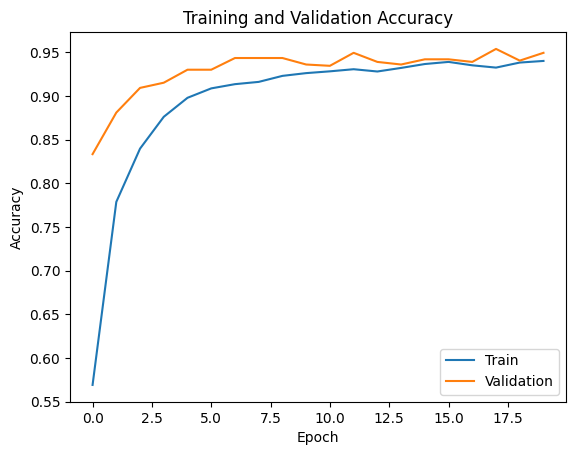

In [7]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

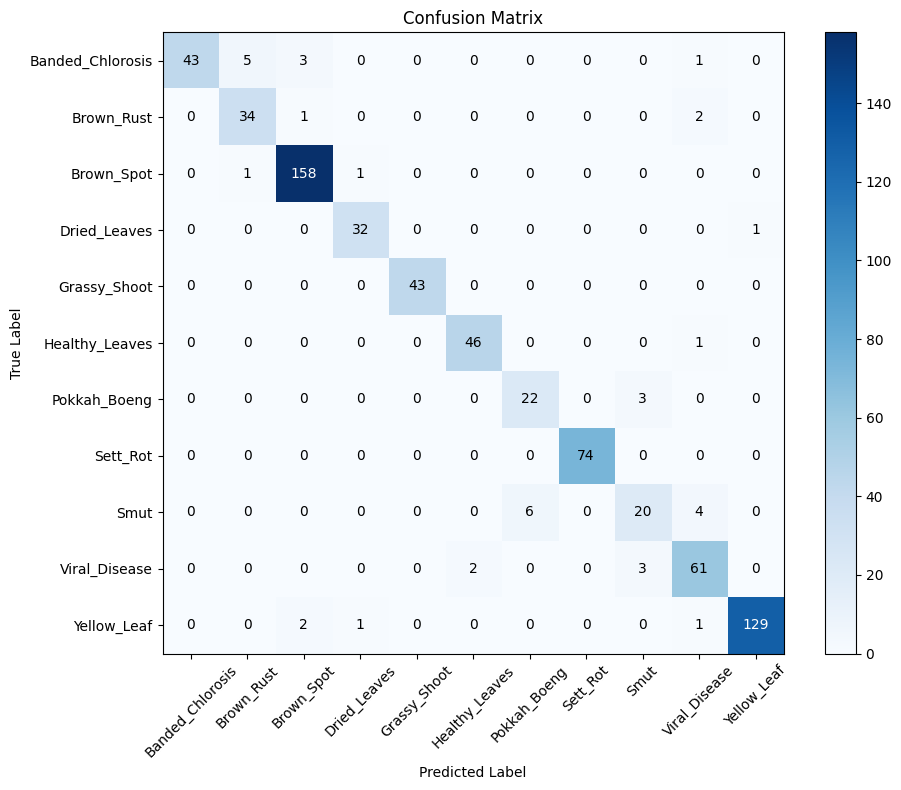

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       1.00      0.74      0.85        50
      Brown_Rust       0.78      0.94      0.85        33
      Brown_Spot       0.98      0.99      0.98       171
    Dried_Leaves       0.91      0.97      0.94        31
    Grassy_Shoot       1.00      1.00      1.00        38
  Healthy_Leaves       0.96      1.00      0.98        43
    Pokkah_Boeng       0.80      0.89      0.84        27
        Sett_Rot       1.00      1.00      1.00        79
            Smut       0.79      0.66      0.72        29
   Viral_Disease       0.87      0.94      0.90        62
     Yellow_Leaf       0.99      0.96      0.97       137

        accuracy                           0.94       700
       macro avg       0.91      0.92      0.91       700
    weighted avg       0.95      0.94      0.94       700



In [10]:
from tensorflow.keras.applications import ResNet50

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 24s 118ms/step - loss: 1.0910 - accuracy: 0.6423 - val_loss: 0.4822 - val_accuracy: 0.8348
Epoch 2/20
168/168 [==============================] - 19s 114ms/step - loss: 0.5852 - accuracy: 0.7915 - val_loss: 0.3110 - val_accuracy: 0.8973
Epoch 3/20
168/168 [==============================] - 19s 114ms/step - loss: 0.4175 - accuracy: 0.8504 - val_loss: 0.2553 - val_accuracy: 0.9092
Epoch 4/20
168/168 [==============================] - 19s 114ms/step - loss: 0.3512 - accuracy: 0.8715 - val_loss: 0.2025 - val_accuracy: 0.9241
Epoch 5/20
168/168 [==============================] - 20s 115ms/step - loss: 0.2813 - accuracy: 0.8988 - val_loss: 0.1558 - val_accuracy: 0.9375
Epoch 6/20
168/168 [==============================] - 19s 114ms/step - loss: 0.2441 - accuracy: 0.9046 - val_loss: 0.1536 - val_accuracy: 0.9420
Epoch 7/20
168/168 [==============================] - 19s 114ms/step - loss: 0.2199 - accuracy: 0.9139 - val_loss: 0.1539 - val_ac

In [11]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 6s 83ms/step - loss: 0.0957 - accuracy: 0.9486


[0.0956793874502182, 0.9485714435577393]

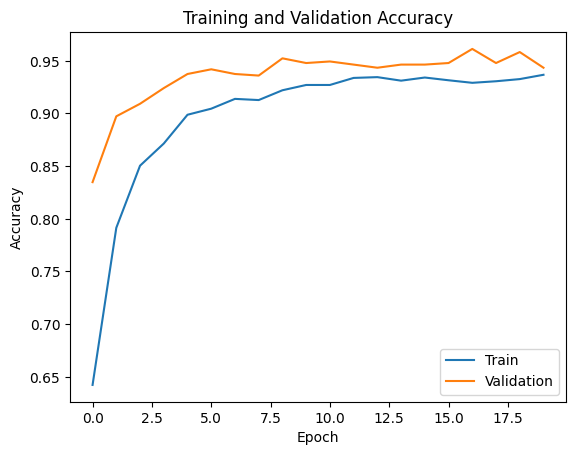

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

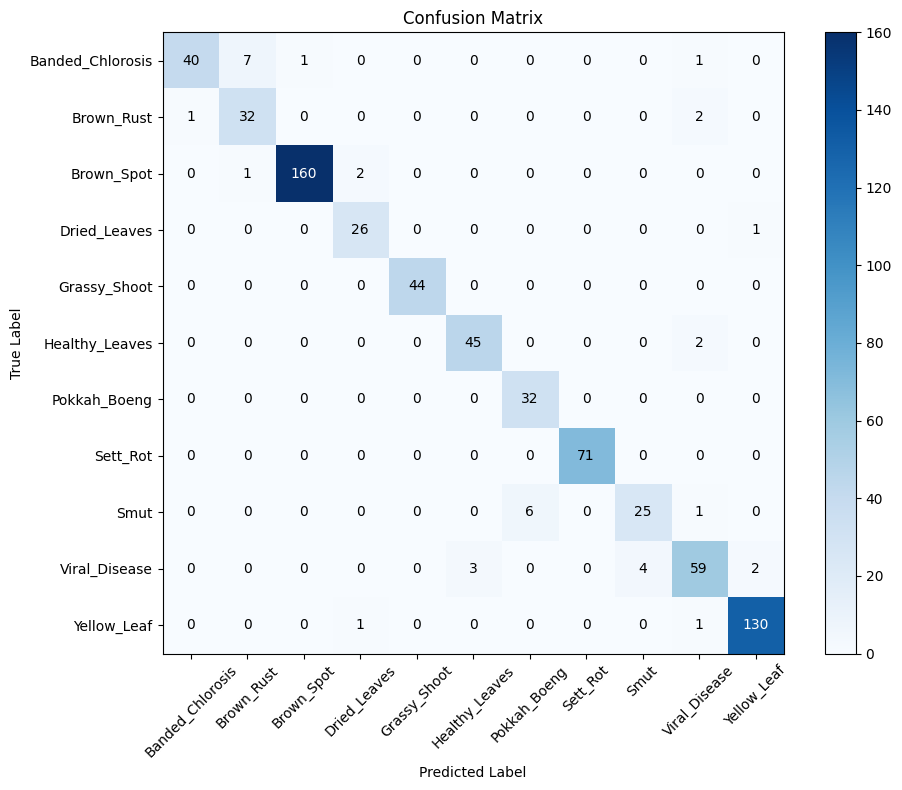

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       1.00      0.85      0.92        47
      Brown_Rust       0.83      0.94      0.88        36
      Brown_Spot       0.99      0.98      0.99       176
    Dried_Leaves       0.87      1.00      0.93        27
    Grassy_Shoot       1.00      1.00      1.00        36
  Healthy_Leaves       0.96      0.98      0.97        45
    Pokkah_Boeng       0.84      1.00      0.91        31
        Sett_Rot       1.00      1.00      1.00        75
            Smut       0.83      0.78      0.81        32
   Viral_Disease       0.89      0.85      0.87        67
     Yellow_Leaf       0.98      0.97      0.98       128

        accuracy                           0.95       700
       macro avg       0.93      0.94      0.93       700
    weighted avg       0.95      0.95      0.95       700



In [15]:
from tensorflow.keras.applications import InceptionV3

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 24s 119ms/step - loss: 5.1609 - accuracy: 0.2591 - val_loss: 1.8781 - val_accuracy: 0.3363
Epoch 2/20
168/168 [==============================] - 19s 111ms/step - loss: 2.0308 - accuracy: 0.3026 - val_loss: 1.7431 - val_accuracy: 0.3378
Epoch 3/20
168/168 [==============================] - 19s 112ms/step - loss: 2.0002 - accuracy: 0.3010 - val_loss: 1.7251 - val_accuracy: 0.3914
Epoch 4/20
168/168 [==============================] - 19s 112ms/step - loss: 1.9528 - accuracy: 0.3010 - val_loss: 1.7437 - val_accuracy: 0.3661
Epoch 5/20
168/168 [==============================] - 19s 112ms/step - loss: 1.9395 - accuracy: 0.3116 - val_loss: 1.6570 - val_accuracy: 0.3720
Epoch 6/20
168/168 [==============================] - 19s 112ms/step - loss: 1.8786 - accuracy: 0.3106 - val_loss: 1.6419 - val_accuracy: 0.3750
Epoch 7/20
168/168 [==============================] - 19s 111ms/step - loss: 1.8483 - accuracy: 0.3272 - val_loss: 1.5335 - val_ac

In [16]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 6s 89ms/step - loss: 1.4587 - accuracy: 0.4471


[1.4587042331695557, 0.4471428692340851]

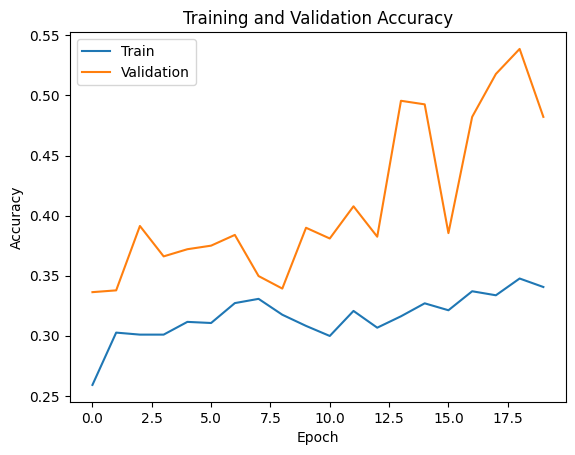

In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

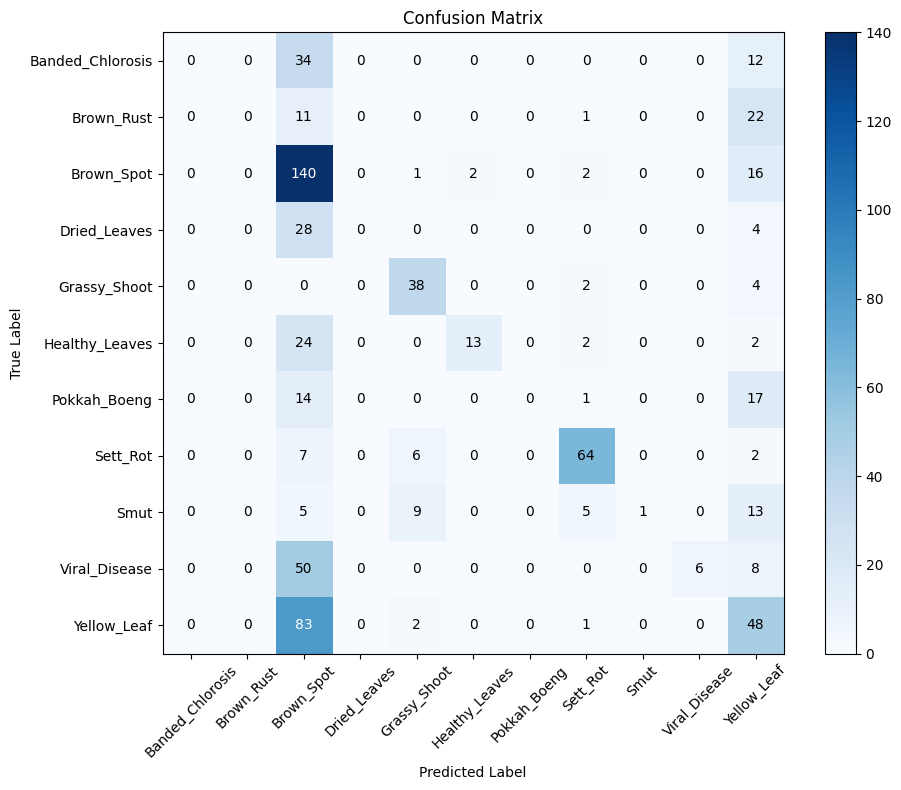

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.00      0.00      0.00        50
      Brown_Rust       0.00      0.00      0.00        35
      Brown_Spot       0.37      0.86      0.52       170
    Dried_Leaves       0.00      0.00      0.00        28
    Grassy_Shoot       0.64      0.79      0.71        38
  Healthy_Leaves       0.88      0.33      0.48        45
    Pokkah_Boeng       0.00      0.00      0.00        27
        Sett_Rot       0.80      0.82      0.81        79
            Smut       1.00      0.03      0.06        33
   Viral_Disease       1.00      0.10      0.19        67
     Yellow_Leaf       0.32      0.38      0.35       128

        accuracy                           0.45       700
       macro avg       0.46      0.30      0.28       700
    weighted avg       0.47      0.45      0.37       700



c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from tensorflow.keras.applications import Xception

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = Xception(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 24s 121ms/step - loss: 5.5929 - accuracy: 0.3160 - val_loss: 1.6106 - val_accuracy: 0.3750
Epoch 2/20
168/168 [==============================] - 20s 119ms/step - loss: 1.7409 - accuracy: 0.4169 - val_loss: 1.3995 - val_accuracy: 0.5119
Epoch 3/20
168/168 [==============================] - 20s 119ms/step - loss: 1.5988 - accuracy: 0.4440 - val_loss: 1.2848 - val_accuracy: 0.5327
Epoch 4/20
168/168 [==============================] - 20s 119ms/step - loss: 1.4910 - accuracy: 0.4701 - val_loss: 1.2054 - val_accuracy: 0.5446
Epoch 5/20
168/168 [==============================] - 20s 119ms/step - loss: 1.4256 - accuracy: 0.4821 - val_loss: 1.2296 - val_accuracy: 0.5655
Epoch 6/20
168/168 [==============================] - 20s 118ms/step - loss: 1.3845 - accuracy: 0.4926 - val_loss: 1.0718 - val_accuracy: 0.5804
Epoch 7/20
168/168 [==============================] - 20s 118ms/step - loss: 1.3231 - accuracy: 0.5149 - val_loss: 1.0508 - val_ac

In [21]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 6s 88ms/step - loss: 0.9568 - accuracy: 0.6071


[0.9567599296569824, 0.6071428656578064]

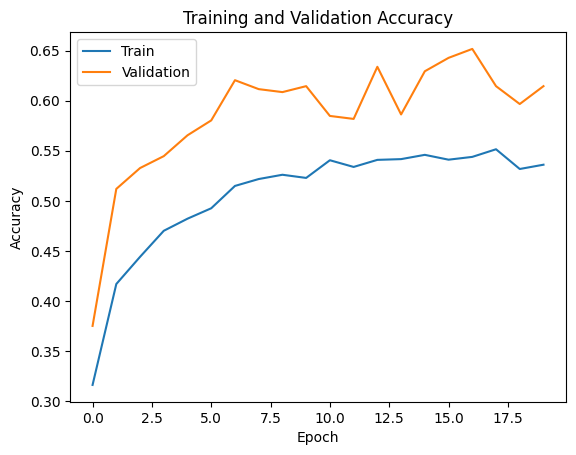

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

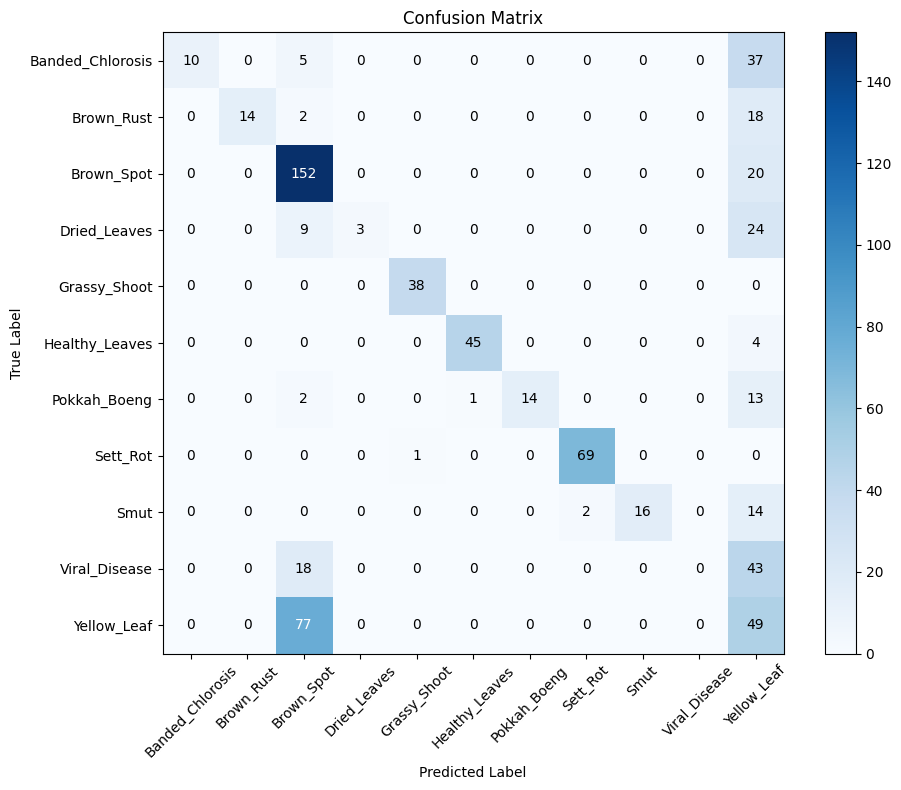

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       1.00      0.17      0.29        47
      Brown_Rust       1.00      0.41      0.58        37
      Brown_Spot       0.57      0.88      0.69       163
    Dried_Leaves       1.00      0.10      0.18        31
    Grassy_Shoot       0.97      1.00      0.99        39
  Healthy_Leaves       0.98      0.96      0.97        45
    Pokkah_Boeng       1.00      0.53      0.70        30
        Sett_Rot       0.99      0.99      0.99        80
            Smut       1.00      0.52      0.68        31
   Viral_Disease       0.00      0.00      0.00        67
     Yellow_Leaf       0.25      0.42      0.31       130

        accuracy                           0.60       700
       macro avg       0.80      0.54      0.58       700
    weighted avg       0.66      0.60      0.57       700



c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from tensorflow.keras.applications import MobileNetV2

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 16s 73ms/step - loss: 1.4550 - accuracy: 0.5175 - val_loss: 0.9570 - val_accuracy: 0.6905
Epoch 2/20
168/168 [==============================] - 12s 70ms/step - loss: 0.9751 - accuracy: 0.6607 - val_loss: 0.6988 - val_accuracy: 0.7783
Epoch 3/20
168/168 [==============================] - 12s 69ms/step - loss: 0.7557 - accuracy: 0.7439 - val_loss: 0.5740 - val_accuracy: 0.8125
Epoch 4/20
168/168 [==============================] - 12s 69ms/step - loss: 0.6227 - accuracy: 0.7857 - val_loss: 0.4747 - val_accuracy: 0.8423
Epoch 5/20
168/168 [==============================] - 12s 69ms/step - loss: 0.5414 - accuracy: 0.8121 - val_loss: 0.3931 - val_accuracy: 0.8690
Epoch 6/20
168/168 [==============================] - 12s 69ms/step - loss: 0.4832 - accuracy: 0.8356 - val_loss: 0.3219 - val_accuracy: 0.9107
Epoch 7/20
168/168 [==============================] - 12s 68ms/step - loss: 0.4286 - accuracy: 0.8434 - val_loss: 0.3389 - val_accuracy:

In [26]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 5s 45ms/step - loss: 0.1725 - accuracy: 0.9200


[0.17253419756889343, 0.9200000166893005]

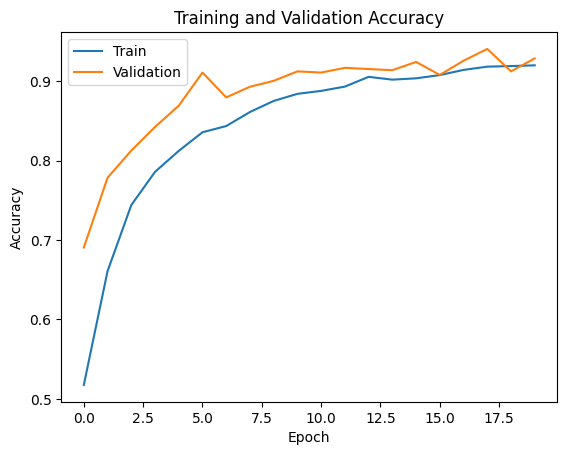

In [27]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

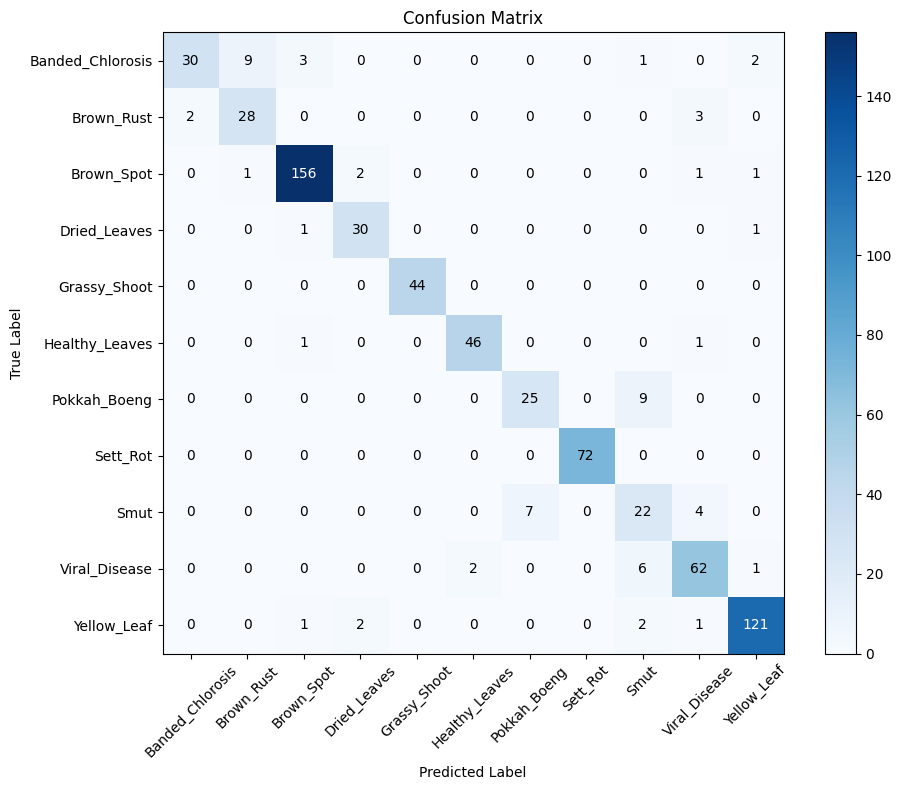

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.94      0.69      0.79        42
      Brown_Rust       0.82      0.89      0.85        35
      Brown_Spot       0.97      0.96      0.96       165
    Dried_Leaves       0.87      0.93      0.90        28
    Grassy_Shoot       1.00      1.00      1.00        43
  Healthy_Leaves       0.96      0.94      0.95        48
    Pokkah_Boeng       0.67      0.74      0.70        27
        Sett_Rot       1.00      1.00      1.00        79
            Smut       0.60      0.58      0.59        36
   Viral_Disease       0.80      0.90      0.85        67
     Yellow_Leaf       0.96      0.95      0.96       130

        accuracy                           0.91       700
       macro avg       0.87      0.87      0.87       700
    weighted avg       0.91      0.91      0.91       700



In [30]:
from tensorflow.keras.applications import EfficientNetB0

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 24s 98ms/step - loss: 0.9748 - accuracy: 0.6706 - val_loss: 0.4290 - val_accuracy: 0.8527
Epoch 2/20
168/168 [==============================] - 15s 89ms/step - loss: 0.5196 - accuracy: 0.8114 - val_loss: 0.2620 - val_accuracy: 0.9167
Epoch 3/20
168/168 [==============================] - 16s 91ms/step - loss: 0.3927 - accuracy: 0.8529 - val_loss: 0.2047 - val_accuracy: 0.9345
Epoch 4/20
168/168 [==============================] - 15s 90ms/step - loss: 0.3269 - accuracy: 0.8785 - val_loss: 0.2086 - val_accuracy: 0.9226
Epoch 5/20
168/168 [==============================] - 15s 90ms/step - loss: 0.2873 - accuracy: 0.8942 - val_loss: 0.1512 - val_accuracy: 0.9449
Epoch 6/20
168/168 [==============================] - 15s 89ms/step - loss: 0.2497 - accuracy: 0.9049 - val_loss: 0.1219 - val_accuracy: 0.9494
Epoch 7/20
168/168 [==============================] - 15s 88ms/step - loss: 0.2337 - accuracy: 0.9098 - val_loss: 0.1406 - val_accuracy:

In [31]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 5s 61ms/step - loss: 0.1175 - accuracy: 0.9443


[0.1174764484167099, 0.9442856907844543]

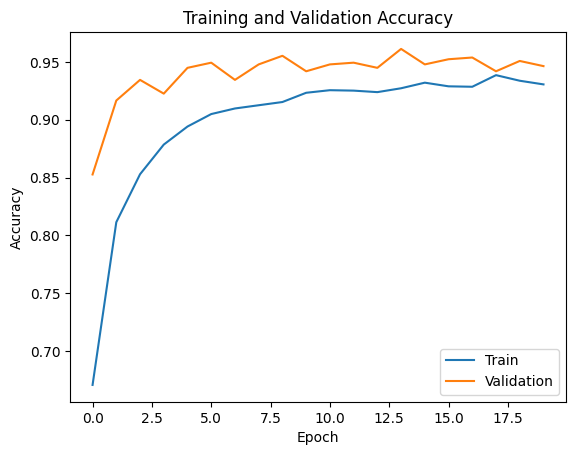

In [32]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

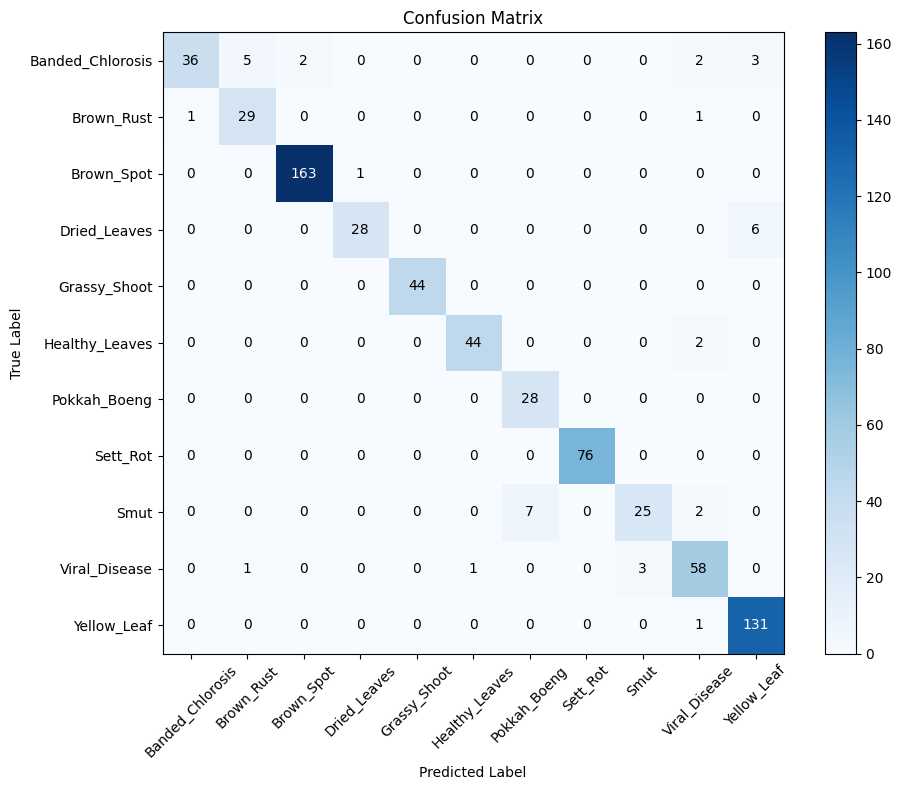

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.95      0.83      0.88        46
      Brown_Rust       0.82      0.89      0.85        35
      Brown_Spot       0.99      0.99      0.99       162
    Dried_Leaves       0.97      0.85      0.90        33
    Grassy_Shoot       1.00      1.00      1.00        43
  Healthy_Leaves       0.98      0.98      0.98        42
    Pokkah_Boeng       0.74      0.93      0.82        27
        Sett_Rot       1.00      1.00      1.00        77
            Smut       0.88      0.68      0.77        34
   Viral_Disease       0.91      0.94      0.93        67
     Yellow_Leaf       0.96      0.99      0.97       134

        accuracy                           0.95       700
       macro avg       0.93      0.92      0.92       700
    weighted avg       0.95      0.95      0.95       700



In [35]:
from tensorflow.keras.applications import DenseNet121

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 29s 139ms/step - loss: 2.1325 - accuracy: 0.4161 - val_loss: 1.1421 - val_accuracy: 0.5952
Epoch 2/20
168/168 [==============================] - 21s 127ms/step - loss: 1.2954 - accuracy: 0.5461 - val_loss: 0.9735 - val_accuracy: 0.6726
Epoch 3/20
168/168 [==============================] - 21s 127ms/step - loss: 1.1130 - accuracy: 0.6032 - val_loss: 0.8418 - val_accuracy: 0.7143
Epoch 4/20
168/168 [==============================] - 22s 127ms/step - loss: 1.0068 - accuracy: 0.6347 - val_loss: 0.7700 - val_accuracy: 0.7530
Epoch 5/20
168/168 [==============================] - 22s 127ms/step - loss: 0.9167 - accuracy: 0.6574 - val_loss: 0.6641 - val_accuracy: 0.7574
Epoch 6/20
168/168 [==============================] - 22s 128ms/step - loss: 0.8636 - accuracy: 0.6897 - val_loss: 0.6327 - val_accuracy: 0.8006
Epoch 7/20
168/168 [==============================] - 22s 127ms/step - loss: 0.8182 - accuracy: 0.7026 - val_loss: 0.5961 - val_ac

In [36]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 6s 95ms/step - loss: 0.3763 - accuracy: 0.8886


[0.37634098529815674, 0.8885714411735535]

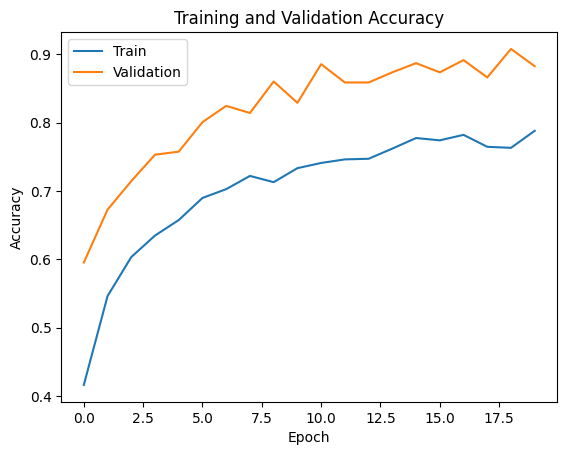

In [37]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

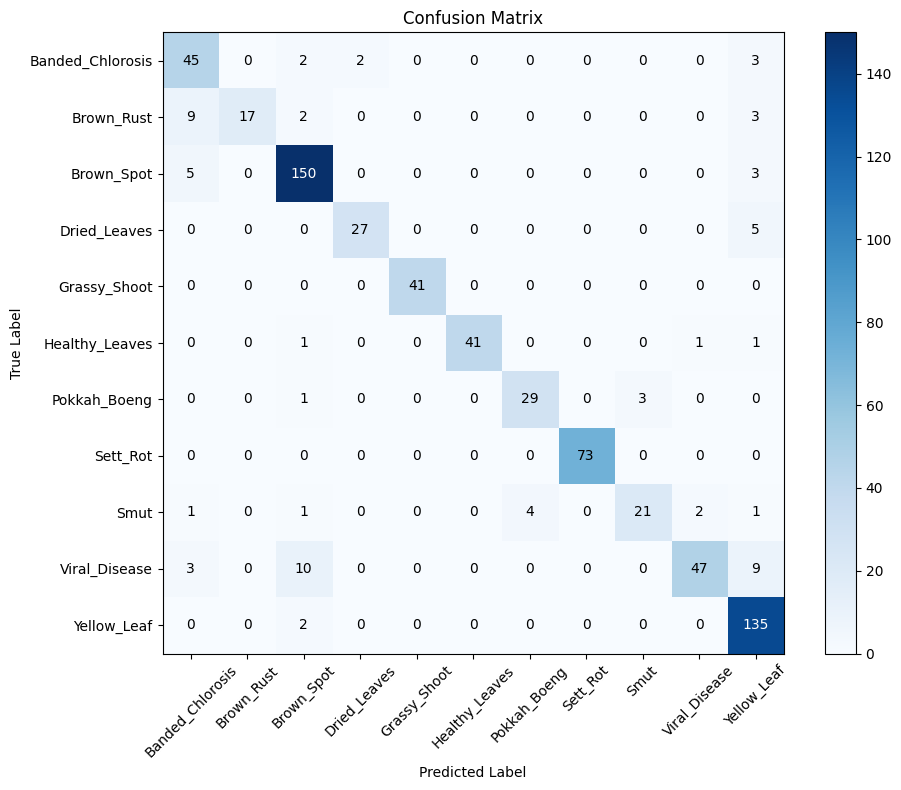

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.70      0.87      0.78        46
      Brown_Rust       1.00      0.66      0.79        29
      Brown_Spot       0.92      0.95      0.93       165
    Dried_Leaves       0.93      0.76      0.83        33
    Grassy_Shoot       1.00      0.98      0.99        43
  Healthy_Leaves       1.00      0.90      0.95        49
    Pokkah_Boeng       0.86      0.92      0.89        26
        Sett_Rot       1.00      1.00      1.00        79
            Smut       0.92      0.71      0.80        31
   Viral_Disease       0.90      0.68      0.78        69
     Yellow_Leaf       0.80      0.98      0.88       130

        accuracy                           0.89       700
       macro avg       0.91      0.85      0.87       700
    weighted avg       0.90      0.89      0.89       700



In [5]:
from tensorflow.keras.applications import NASNetMobile

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 38s 115ms/step - loss: 3.2037 - accuracy: 0.2746 - val_loss: 1.6315 - val_accuracy: 0.4524
Epoch 2/20
168/168 [==============================] - 16s 94ms/step - loss: 1.7563 - accuracy: 0.3930 - val_loss: 1.4919 - val_accuracy: 0.5030
Epoch 3/20
168/168 [==============================] - 16s 95ms/step - loss: 1.5893 - accuracy: 0.4466 - val_loss: 1.4134 - val_accuracy: 0.5089
Epoch 4/20
168/168 [==============================] - 16s 97ms/step - loss: 1.5052 - accuracy: 0.4760 - val_loss: 1.3101 - val_accuracy: 0.5357
Epoch 5/20
168/168 [==============================] - 16s 95ms/step - loss: 1.4402 - accuracy: 0.4874 - val_loss: 1.2665 - val_accuracy: 0.5759
Epoch 6/20
168/168 [==============================] - 16s 95ms/step - loss: 1.3831 - accuracy: 0.5153 - val_loss: 1.2230 - val_accuracy: 0.5952
Epoch 7/20
168/168 [==============================] - 17s 97ms/step - loss: 1.3240 - accuracy: 0.5242 - val_loss: 1.1570 - val_accuracy

In [6]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 5s 64ms/step - loss: 0.8259 - accuracy: 0.7014


[0.8258889317512512, 0.7014285922050476]

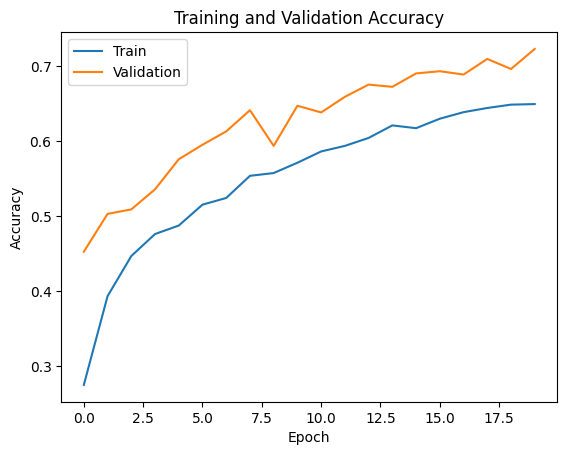

In [7]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

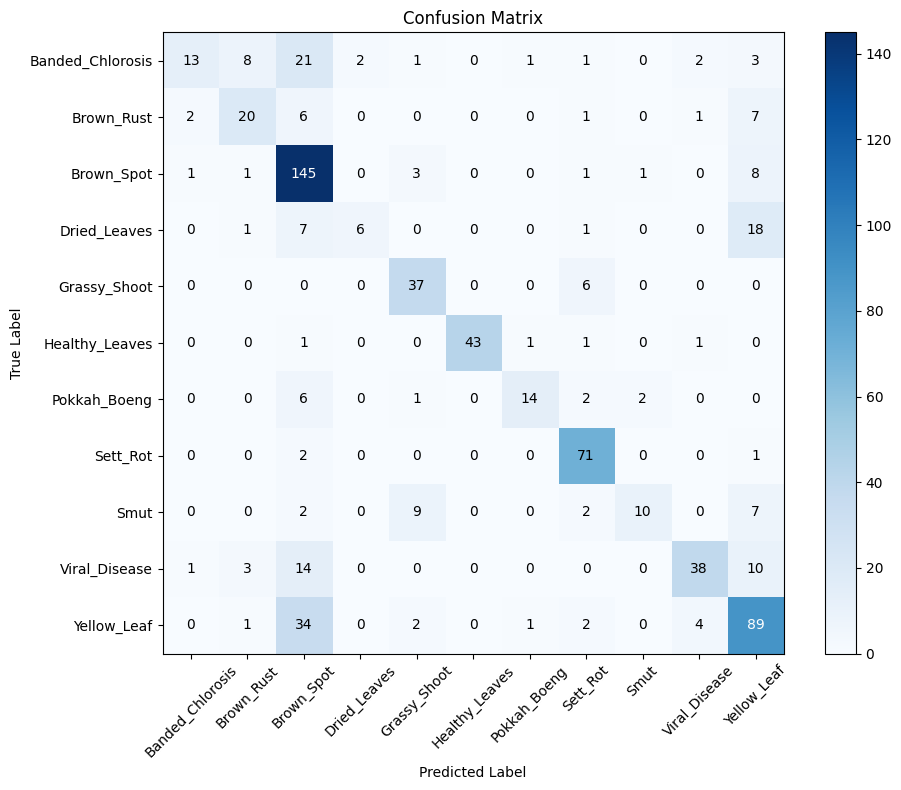

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.87      0.26      0.40        50
      Brown_Rust       0.55      0.55      0.55        33
      Brown_Spot       0.64      0.90      0.75       171
    Dried_Leaves       0.75      0.19      0.31        31
    Grassy_Shoot       0.74      0.89      0.81        38
  Healthy_Leaves       0.98      0.93      0.95        43
    Pokkah_Boeng       0.79      0.56      0.65        27
        Sett_Rot       0.81      0.95      0.87        79
            Smut       0.79      0.38      0.51        29
   Viral_Disease       0.81      0.63      0.71        62
     Yellow_Leaf       0.64      0.67      0.66       137

        accuracy                           0.71       700
       macro avg       0.76      0.63      0.65       700
    weighted avg       0.73      0.71      0.69       700



In [10]:
from tensorflow.keras.applications import InceptionResNetV2

# Get the number of classes and set up the base model
num_classes = len(dataset.class_names)

def build_pretrained_model():
    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(iz, iz, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classifier on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


model = build_pretrained_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = 20
)

Epoch 1/20
168/168 [==============================] - 46s 208ms/step - loss: 41.4239 - accuracy: 0.2232 - val_loss: 2.3526 - val_accuracy: 0.2292
Epoch 2/20
168/168 [==============================] - 33s 193ms/step - loss: 2.5926 - accuracy: 0.2587 - val_loss: 2.2989 - val_accuracy: 0.2589
Epoch 3/20
168/168 [==============================] - 33s 193ms/step - loss: 2.2862 - accuracy: 0.2602 - val_loss: 2.2657 - val_accuracy: 0.2515
Epoch 4/20
168/168 [==============================] - 32s 191ms/step - loss: 2.2574 - accuracy: 0.2578 - val_loss: 2.2486 - val_accuracy: 0.2440
Epoch 5/20
168/168 [==============================] - 33s 193ms/step - loss: 2.2352 - accuracy: 0.2587 - val_loss: 2.2209 - val_accuracy: 0.2366
Epoch 6/20
168/168 [==============================] - 33s 194ms/step - loss: 2.2200 - accuracy: 0.2593 - val_loss: 2.2155 - val_accuracy: 0.2634
Epoch 7/20
168/168 [==============================] - 32s 191ms/step - loss: 2.2105 - accuracy: 0.2586 - val_loss: 2.2165 - val_a

In [11]:
scores = model.evaluate(testing_ds)
scores

22/22 [==============================] - 8s 163ms/step - loss: 2.2165 - accuracy: 0.2371


[2.2165088653564453, 0.23714286088943481]

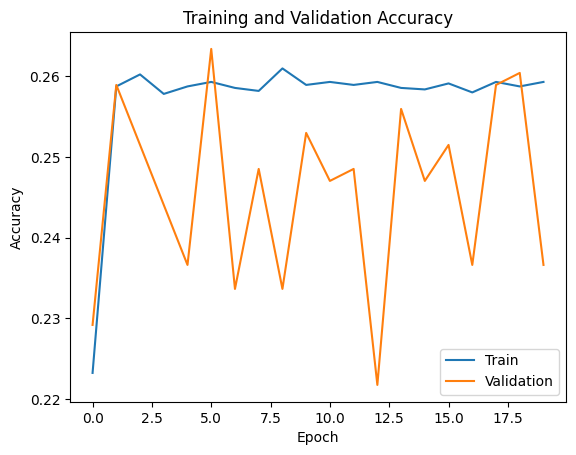

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

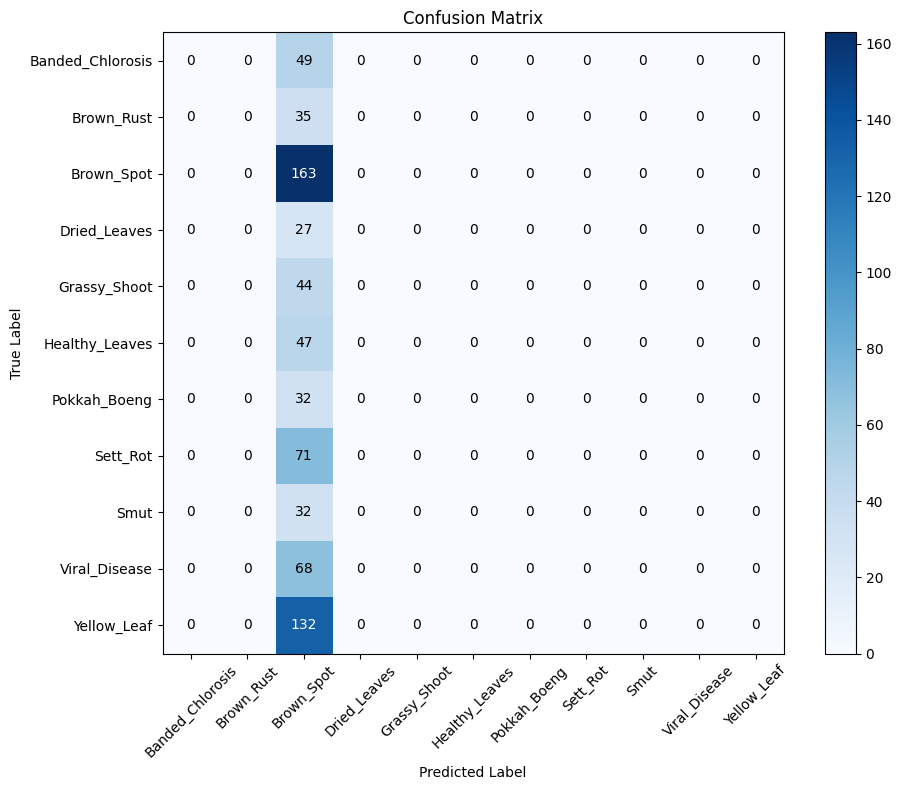

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.00      0.00      0.00        47
      Brown_Rust       0.00      0.00      0.00        36
      Brown_Spot       0.25      1.00      0.40       176
    Dried_Leaves       0.00      0.00      0.00        27
    Grassy_Shoot       0.00      0.00      0.00        36
  Healthy_Leaves       0.00      0.00      0.00        45
    Pokkah_Boeng       0.00      0.00      0.00        31
        Sett_Rot       0.00      0.00      0.00        75
            Smut       0.00      0.00      0.00        32
   Viral_Disease       0.00      0.00      0.00        67
     Yellow_Leaf       0.00      0.00      0.00       128

        accuracy                           0.25       700
       macro avg       0.02      0.09      0.04       700
    weighted avg       0.06      0.25      0.10       700



c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baldo\anaconda3\envs\gpu1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
